# Random Forest Model

RF is one of the models we applied to predict deaths for COVID-patients in Mexico.
It is worth noting that the data is highly imbalanced, and Random Forest doesn't work well with imbalanced data because it aims to minimize the overall error rate, rather than paying special attention to the positive class.
To alleviate the problem, we follow two proposed models by [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf): balanced random forest (BRF) and weighted random forest (WRF).

In [1]:
import pre_ml
%load_ext autoreload
%autoreload 2
import mlpipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install -U imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix

In [2]:
df = pre_ml.data(False)
df.head(10)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory


,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,...,obesidad,tabaquismo,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras,hospitalizado,muertos,covid_grave
0,9,2,9002,0.0,78,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,17.4,12184.994033,6.292218,43.286546,114.312716,1,1,1
1,28,22,28022,0.0,34,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,41.2,117.872737,1.464893,6.170861,13.000925,0,0,0
2,15,33,15033,0.0,37,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.6,10709.607425,1.147706,4.807484,14.258494,0,0,0
3,8,37,8037,0.0,55,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,38.8,412.948310,0.873762,7.229014,18.349000,1,1,1
4,25,6,25006,0.0,84,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,31.2,152.715706,2.637944,10.489463,30.502528,1,1,1
5,15,57,15057,0.0,41,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,32.9,5792.941701,0.648218,4.691344,13.579627,0,0,0
6,15,121,15121,0.0,22,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.8,5264.890997,0.779639,2.390894,6.167813,0,0,0
7,15,13,15013,0.0,45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.4,6112.661839,1.597536,3.661768,10.016011,0,0,0
8,9,5,9005,0.0,40,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,31.2,13388.317598,2.871788,17.519608,46.509375,0,0,0
9,15,87,15087,0.0,33,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,64.5,578.261559,1.370664,1.644797,8.772250,1,0,1


## 1. Pre-process

### 1.1 Split data and define features/target variables

In [3]:
#1st Step: Split
train, test = mlpipeline.split_data(df, test_size=0.2, seed=0)
print('Training data observations:{}'.format(train.shape[0]))
print('Testing data observations:{}'.format(test.shape[0]))
print('Training observations of Deaths=1 and no Deaths=0')
print(train['hospitalizado'].value_counts()/train.shape[0])

Training data observations:99440
Testing data observations:24861
Training observations of Deaths=1 and no Deaths=0
0    0.666714
1    0.333286
Name: hospitalizado, dtype: float64


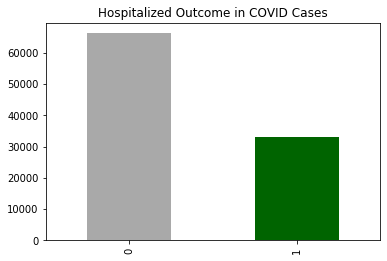

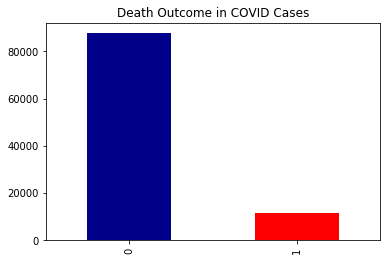

In [4]:
train['hospitalizado'].value_counts().plot(kind='bar', color=['darkgrey', 'darkgreen'])
plt.title('Hospitalized Outcome in COVID Cases')
plt.show()
train['muertos'].value_counts().plot(kind='bar', color=['darkblue', 'red'])
plt.title('Death Outcome in COVID Cases')
plt.show()

_As seen in the data, only 11% corresponds to one label. When doing Cross Validation, some samples may not have the label = 1 in their data. So, we must take into account some balance techniques._

In [5]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target = ['muertos']

## 2. Model Learning and Evaluation: Random Forest

### 2.2 Balanced Random Forest Classifier
From [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf), 
the BRF algorithm works as follows:  
1. For each iteration in random forest, draw a bootstrap sample from the minority class. Randomly draw the same number of cases, with replacement, from the majority class.
2. Induce a classification tree from the data to maximum size, without pruning. The tree is induced with the CART algorithm, with the following modification: At each node, instead of searching through all variables for the optimal split, only search through a set of m randomly selected variables.
3. Repeat the two steps above for the number of times desired. Aggregate the predictions of the ensemble and make the final prediction.

In [6]:
from sklearn.model_selection import GridSearchCV
params = {'criterion':['gini', 'entropy'], 'max_depth':[5,10, 15],
         'min_samples_split':[10, 15]}       
grid_parameters={'estimator':BalancedRandomForestClassifier(random_state=0), 
                          'param_grid':params, 
                          'cv':10,
                          'return_train_score':True,
                          'scoring':['recall', 'precision'],
                           'refit' : 'recall'}

#### 2.2.1 Target: Death

In [7]:
grid_brf_d =GridSearchCV(**grid_parameters)
grid_brf_d.fit(train[features],train[target].values.ravel())
brf_results = pd.DataFrame(grid_brf_d.cv_results_)

In [10]:
pd.set_option('mode.chained_assignment', None)
cols_to_keep = ['param_criterion','param_max_depth', 'param_min_samples_split',
                'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
brf_results = brf_results[cols_to_keep]
brf_results.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
6,entropy,5,10,1,0.817795,0.820947,0.239251,0.240183
7,entropy,5,15,2,0.816861,0.820249,0.239275,0.240056
1,gini,5,15,3,0.812531,0.814588,0.241117,0.241895
0,gini,5,10,4,0.812276,0.814900,0.241179,0.242004
8,entropy,10,10,5,0.807607,0.829277,0.249622,0.256108
9,entropy,10,15,6,0.806757,0.828862,0.248528,0.255288
3,gini,10,15,7,0.805314,0.828286,0.249378,0.256279
2,gini,10,10,8,0.804210,0.828767,0.249651,0.257269
11,entropy,15,15,9,0.800560,0.847833,0.254286,0.269400
10,entropy,15,10,10,0.800475,0.854276,0.254389,0.271712


Best Balanced Random Forest Model to predict Death: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
Model's Accuracy on test data: 0.67
Model's Precision on test data: 0.23
Model's Recall on test data: 0.81
Model's F1 Score: 0.364


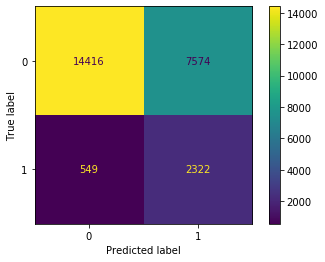

In [11]:
print('Best Balanced Random Forest Model to predict Death: {}'.format(grid_brf_d.best_params_))
mlpipeline.confusion_metrics(grid_brf_d.best_estimator_, test, features, target)

#### 2.2.1 Target: Hospitalization

In [8]:
target2 = 'hospitalizado'

In [12]:
#Train the model with hospitalizado
grid_brf_h = GridSearchCV(**grid_parameters)
grid_brf_h.fit(train[features], train[target2])
#Store the results
brf_results_hos = pd.DataFrame(grid_brf_h.cv_results_)
brf_results_hos = brf_results_hos[cols_to_keep]
brf_results_hos.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results_hos.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
5,gini,15,15,1,0.727054,0.762296,0.552603,0.582274
11,entropy,15,15,2,0.725877,0.761213,0.552217,0.581261
3,gini,10,15,3,0.724549,0.736239,0.546909,0.556578
10,entropy,15,10,4,0.724217,0.763559,0.552496,0.584302
8,entropy,10,10,5,0.724187,0.736531,0.545703,0.555873
7,entropy,5,15,6,0.724127,0.726356,0.532855,0.534218
6,entropy,5,10,7,0.724066,0.726306,0.532774,0.534086
9,entropy,10,15,8,0.724006,0.736400,0.545457,0.555810
4,gini,15,10,9,0.723705,0.765001,0.552460,0.586012
2,gini,10,10,10,0.723252,0.735321,0.547495,0.557961


Best Balanced Random Forest Model to predict hospitalization: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10}
Model's Accuracy on test data: 0.74
Model's Precision on test data: 0.59
Model's Recall on test data: 0.75
Model's F1 Score: 0.659


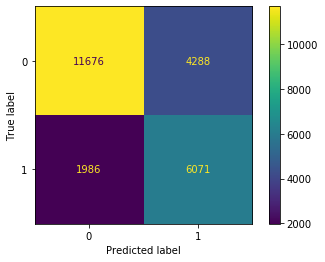

In [91]:
print('Best Balanced Random Forest Model to predict hospitalization: {}'.format(grid_brf_h.best_params_))
mlpipeline.confusion_metrics(grid_brf_h.best_estimator_, test, features, target2)

#### 2.2.3 Target: Severe Condition (i.e. Death or Hospitalized)

In [12]:
target3 = 'covid_grave'

In [13]:
#Train the model with severe condition
grid_brf_s = GridSearchCV(**grid_parameters)
grid_brf_s.fit(train[features], train[target3])
#Store results in severe df
brf_results_severe = pd.DataFrame(grid_brf_s.cv_results_)[cols_to_keep]
brf_results_severe.rename(columns = {'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
brf_results_severe.sort_values(by='rank_test_recall')

,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
11,entropy,15,15,1,0.721225,0.761005,0.587737,0.622519
5,gini,15,15,2,0.720882,0.762634,0.586606,0.623483
9,entropy,10,15,3,0.720194,0.734438,0.582051,0.594119
8,entropy,10,10,4,0.719965,0.735113,0.582683,0.595234
10,entropy,15,10,5,0.719889,0.763678,0.587344,0.626504
4,gini,15,10,6,0.719583,0.765698,0.587721,0.628709
2,gini,10,10,7,0.718858,0.735737,0.582096,0.596369
3,gini,10,15,8,0.718437,0.733899,0.582566,0.595937
7,entropy,5,15,9,0.715803,0.717983,0.572061,0.574077
6,entropy,5,10,10,0.715115,0.717737,0.572083,0.574249


Best Balanced Random Forest Model to predict severe condition : {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 15}
Model's Accuracy on test data: 0.72
Model's Precision on test data: 0.59
Model's Recall on test data: 0.73
Model's F1 Score: 0.652


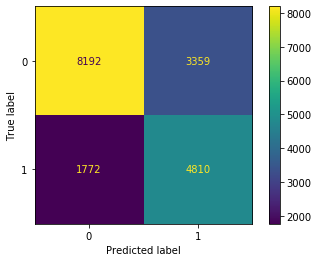

In [14]:
print('Best Balanced Random Forest Model to predict severe condition : {}'.format(grid_brf_s.best_params_))
mlpipeline.confusion_metrics(grid_brf_s.best_estimator_, test, features, target3)

### 2.2 Weighted Random Forest Classifier

The regular RF classifier tends to be biased towards the majority class, so the weighted random forest places a heavier penalty on misclassifying the minority class (i.e. the minority class is given a larger weight). 
The weights are used in the tree induction procedure (the splits) and in the terminal nodes (class determined by weighted majority vote).

For more applied models for imbalanced data: [link](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

In [15]:
from sklearn.ensemble import RandomForestClassifier
params = {'criterion':['gini', 'entropy'], 'max_depth':[10, 15],'class_weight':['balanced', 'balanced_subsample'],
         'min_samples_split':[10, 15]}
grid_parameters_w={'estimator':RandomForestClassifier(random_state=0), 
                          'param_grid':params, 
                          'cv':10,
                          'return_train_score':True,
                          'scoring':['recall', 'precision'],
                           'refit' : 'recall'}

#### 2.2.1 Target: Death

In [16]:
grid_wrf_d = GridSearchCV(**grid_parameters_w)
grid_wrf_d.fit(train[features],train[target].values.ravel())
wrf_results = pd.DataFrame(grid_wrf_d.cv_results_)

In [17]:
cols_to_keep = ['param_class_weight','param_criterion','param_max_depth', 'param_min_samples_split', 
                'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
wrf_results = wrf_results[cols_to_keep]
wrf_results.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
13,balanced_subsample,entropy,10,15,1,0.765892,0.813615,0.235312,0.250556
5,balanced,entropy,10,15,2,0.764761,0.815094,0.235471,0.250715
1,balanced,gini,10,15,3,0.764635,0.816378,0.235543,0.251679
9,balanced_subsample,gini,10,15,4,0.762625,0.815331,0.235830,0.252457
12,balanced_subsample,entropy,10,10,5,0.762249,0.815443,0.235164,0.251715
4,balanced,entropy,10,10,6,0.760492,0.813768,0.235931,0.252473
8,balanced_subsample,gini,10,10,7,0.760491,0.816350,0.236038,0.253637
0,balanced,gini,10,10,8,0.760240,0.816099,0.235801,0.253412
15,balanced_subsample,entropy,15,15,9,0.660388,0.828072,0.257256,0.320678
7,balanced,entropy,15,15,10,0.659007,0.828533,0.256351,0.321038


Best Weighted Random Forest Model to predict death: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}
Model's Accuracy on test data: 0.69
Model's Precision on test data: 0.23
Model's Recall on test data: 0.77
Model's F1 Score: 0.349


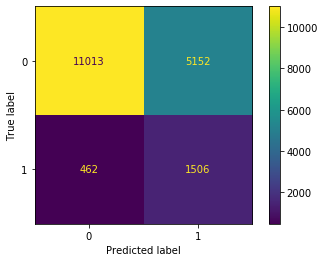

In [18]:
print('Best Weighted Random Forest Model to predict death: {}'.format(grid_wrf_d.best_params_))
mlpipeline.confusion_metrics(grid_wrf_d.best_estimator_, test, features, target)

#### 2.2.2 Target: Hospitalization

In [19]:
grid_wrf_h = GridSearchCV(**grid_parameters_w)
grid_wrf_h.fit(train[features],train[target2].values.ravel())
wrf_results_hos = pd.DataFrame(grid_wrf_h.cv_results_)[cols_to_keep]
wrf_results_hos.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results_hos.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
4,balanced,entropy,10,10,1,0.711347,0.730720,0.565835,0.581269
0,balanced,gini,10,10,2,0.710755,0.730558,0.566279,0.583419
12,balanced_subsample,entropy,10,10,3,0.710559,0.729726,0.565387,0.581407
8,balanced_subsample,gini,10,10,4,0.710401,0.730593,0.566197,0.583373
9,balanced_subsample,gini,10,15,5,0.710401,0.730111,0.565646,0.581871
13,balanced_subsample,entropy,10,15,6,0.710007,0.729432,0.565000,0.580333
1,balanced,gini,10,15,7,0.709888,0.730264,0.565758,0.582101
5,balanced,entropy,10,15,8,0.709888,0.729244,0.564879,0.580396
7,balanced,entropy,15,15,9,0.694163,0.752821,0.579310,0.631750
3,balanced,gini,15,15,10,0.692429,0.754656,0.579300,0.634516


Best Weighted Random Forest Model to predict Hospitalization: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Model's Accuracy on test data: 0.71
Model's Precision on test data: 0.57
Model's Recall on test data: 0.73
Model's F1 Score: 0.635


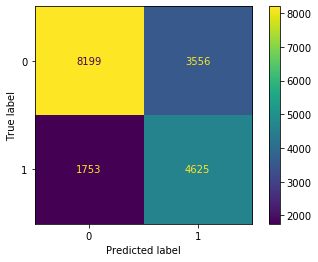

In [20]:
print('Best Weighted Random Forest Model to predict Hospitalization: {}'.format(grid_wrf_h.best_params_))
mlpipeline.confusion_metrics(grid_wrf_h.best_estimator_, test, features, target2)

#### 2.2.3 Target: Severe Condition (Death or Hospitalized)

In [21]:
grid_wrf_s = GridSearchCV(**grid_parameters_w)
grid_wrf_s.fit(train[features],train[target3].values.ravel())
wrf_results_sev = pd.DataFrame(grid_wrf_s.cv_results_)[cols_to_keep]
wrf_results_sev.rename(columns = {'param_class_weight':'class_weight',
                            'param_criterion':'criterion',
                             'param_max_depth': 'depth', 
                             'param_min_samples_split': 'min_samples_split'}, inplace=True)
wrf_results_sev.sort_values(by='rank_test_recall')

,class_weight,criterion,depth,min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
5,balanced,entropy,10,15,1,0.713320,0.729262,0.585677,0.600304
13,balanced_subsample,entropy,10,15,2,0.713053,0.729164,0.585955,0.600549
12,balanced_subsample,entropy,10,10,3,0.712099,0.730114,0.585437,0.601130
1,balanced,gini,10,15,4,0.711793,0.730284,0.585962,0.601765
9,balanced_subsample,gini,10,15,5,0.711716,0.730271,0.585822,0.601708
8,balanced_subsample,gini,10,10,6,0.711259,0.730488,0.587018,0.603100
4,balanced,entropy,10,10,7,0.710914,0.729160,0.586843,0.602039
0,balanced,gini,10,10,8,0.710380,0.729868,0.586466,0.603241
15,balanced_subsample,entropy,15,15,9,0.698312,0.752739,0.598233,0.648726
7,balanced,entropy,15,15,10,0.697472,0.752926,0.598182,0.648797


Best Weighted Random Forest Model to predict Severe Condition: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}
Model's Accuracy on test data: 0.71
Model's Precision on test data: 0.58
Model's Recall on test data: 0.73
Model's F1 Score: 0.649


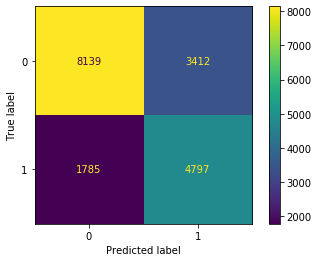

In [22]:
print('Best Weighted Random Forest Model to predict Severe Condition: {}'.format(grid_wrf_s.best_params_))
mlpipeline.confusion_metrics(grid_wrf_s.best_estimator_, test, features, target3)

### 2.3 Random Forest with SMOTE

Another technique to deal with imbalanced data is to apply Synthetic Minority Over-sampling Technique (SMOTE).
Unlike the over-sampling techniques that repeats the same information, new examples can be synthesized from the existing examples to boost the minority class.
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
pipeline = Pipeline([('sm',SMOTE(random_state=0)),
                     ('rf',RandomForestClassifier(random_state=0))])
params = dict(rf__criterion=['gini', 'entropy'],
                      rf__max_depth=[10,15],
             rf__min_samples_split= [10,25])    
grid_srf = GridSearchCV(estimator=pipeline, 
                          param_grid=params, 
                          cv=10,
                          return_train_score=True,
                          scoring=['recall', 'precision'],
                           refit = 'recall')                 

#### 2.3.1 Target: Death

In [35]:
grid_srf.fit(train[features], train[target].values.ravel())
srf_results = pd.DataFrame(grid_srf.cv_results_)
cols_keep = ['param_rf__criterion', 'param_rf__max_depth', 'param_rf__min_samples_split', 
             'rank_test_recall','mean_test_recall','mean_train_recall', 
                'mean_test_precision','mean_train_precision']
srf_results = srf_results[cols_keep]
srf_results.sort_values(by='rank_test_recall')

,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
1,gini,10,25,1,0.378182,0.430140,0.293695,0.328828
0,gini,10,10,2,0.374033,0.438360,0.290929,0.334602
4,entropy,10,10,3,0.372280,0.425702,0.296027,0.335031
5,entropy,10,25,4,0.369642,0.419730,0.292967,0.326629
2,gini,15,10,5,0.284859,0.455120,0.297891,0.439335
3,gini,15,25,6,0.283728,0.416785,0.297480,0.411921
6,entropy,15,10,7,0.280464,0.436155,0.302405,0.437819
7,entropy,15,25,8,0.279456,0.403821,0.301931,0.412166


Best Random Forest Model(w/ SMOTE) to predict Death: {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__min_samples_split': 25}
Model's Accuracy on test data: 0.82
Model's Precision on test data: 0.28
Model's Recall on test data: 0.39
Model's F1 Score: 0.322


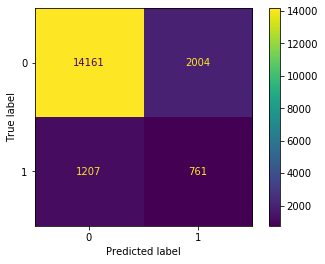

In [36]:
print('Best Random Forest Model(w/ SMOTE) to predict Death: {}'.format(grid_srf.best_params_))
mlpipeline.confusion_metrics(grid_srf.best_estimator_.get_params()['steps'][1][1], test, features, target)

#### 2.3.2 Target: Hospitalization

In [37]:
grid_srf.fit(train[features], train[target2].values.ravel())
srf_results_hos = pd.DataFrame(grid_srf.cv_results_)[cols_keep]
srf_results.sort_values(by='rank_test_recall')

,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
1,gini,10,25,1,0.378182,0.430140,0.293695,0.328828
0,gini,10,10,2,0.374033,0.438360,0.290929,0.334602
4,entropy,10,10,3,0.372280,0.425702,0.296027,0.335031
5,entropy,10,25,4,0.369642,0.419730,0.292967,0.326629
2,gini,15,10,5,0.284859,0.455120,0.297891,0.439335
3,gini,15,25,6,0.283728,0.416785,0.297480,0.411921
6,entropy,15,10,7,0.280464,0.436155,0.302405,0.437819
7,entropy,15,25,8,0.279456,0.403821,0.301931,0.412166


Best Random Forest Model(w/ SMOTE) to predict Hospitalization: {'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__min_samples_split': 10}
Model's Accuracy on test data: 0.72
Model's Precision on test data: 0.59
Model's Recall on test data: 0.66
Model's F1 Score: 0.626


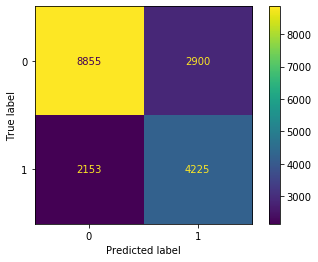

In [38]:
print('Best Random Forest Model(w/ SMOTE) to predict Hospitalization: {}'.format(grid_srf.best_params_))
mlpipeline.confusion_metrics(grid_srf.best_estimator_.get_params()['steps'][1][1], test, features, target2)

#### 2.3.3 Target: Severe Condition (i.e. Death or Hospitalization)

In [39]:
grid_srf.fit(train[features], train[target3].values.ravel())
srf_results_sev = pd.DataFrame(grid_srf.cv_results_)[cols_keep]
srf_results_sev.sort_values(by='rank_test_recall')

,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_split,rank_test_recall,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision
5,entropy,10,25,1,0.664133,0.679642,0.608720,0.623515
1,gini,10,25,2,0.663828,0.680453,0.607967,0.625204
4,entropy,10,10,3,0.663026,0.681340,0.608373,0.626136
0,gini,10,10,4,0.661804,0.681055,0.609204,0.628077
7,entropy,15,25,5,0.641564,0.692236,0.620097,0.668516
3,gini,15,25,6,0.640648,0.695049,0.618631,0.670077
2,gini,15,10,7,0.637096,0.705453,0.620032,0.687182
6,entropy,15,10,8,0.636715,0.701354,0.620826,0.683790


Best Random Forest Model(w/ SMOTE) to predict Severe Condition: {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__min_samples_split': 25}
Model's Accuracy on test data: 0.73
Model's Precision on test data: 0.61
Model's Recall on test data: 0.67
Model's F1 Score: 0.64


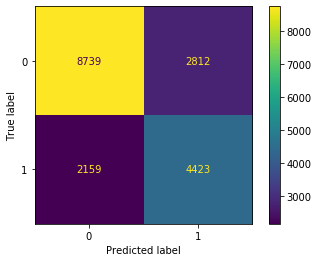

In [40]:
print('Best Random Forest Model(w/ SMOTE) to predict Severe Condition: {}'.format(grid_srf.best_params_))
mlpipeline.confusion_metrics(grid_srf.best_estimator_.get_params()['steps'][1][1], test, features, target3)

## 3. Feature Importance

From BalanceRF and Weighted RF models, we show the features' importances to predict deaths for COVID-19 patients.

### 3.1 Target Variable: Death

In [14]:
d = {'edad': 'Age', 'diabetes': 'Diabetes', 'epoc':'Pulmonary \ndisease', 'asma': 'Asthma',
    'inmusupr': 'Immunosuppression', 'hipertension': 'Hypertension', 'cardiovascular':'Cardiovascular', 
     'obesidad':'Obesity','tabaquismo':'Smoking','pobreza':'Poverty',
     'medicos':'Doctors', 'camas_hosp':'Hospital Beds', 'enfermeras':'Nurses'}
features_en = [d[f] for f in features]

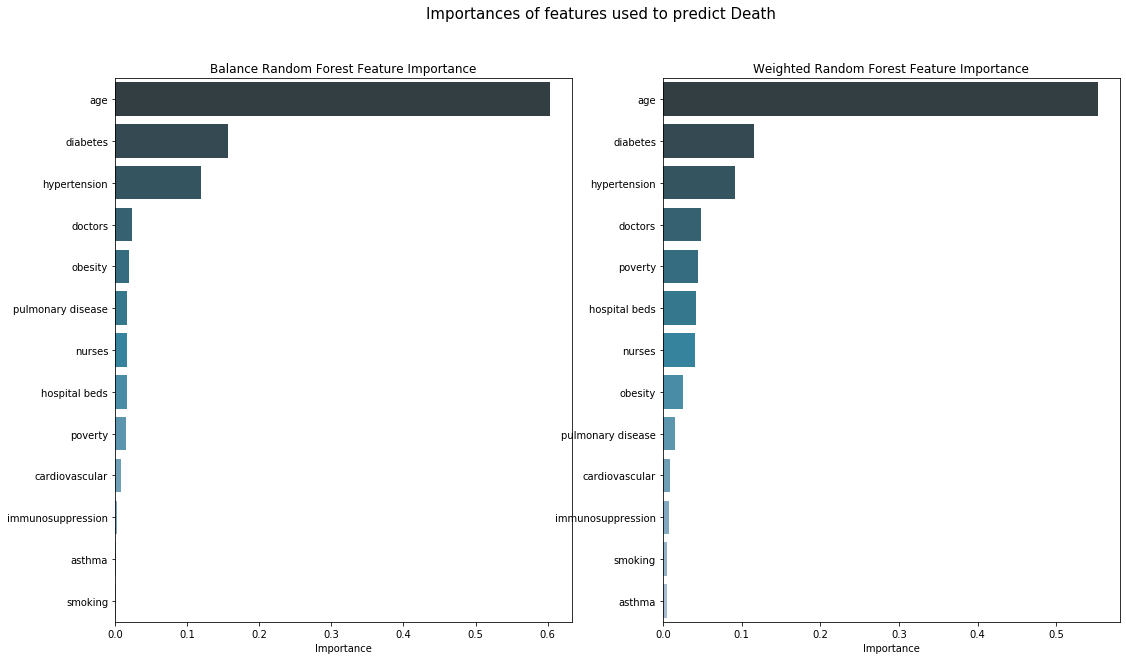

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf_d.best_estimator_, ax1), (grid_wrf_d.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="PuBuGn_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
fig.suptitle('Importances of features used to predict Death', size=15)
plt.show()

### 3.2 Target Variable: Hospitalized

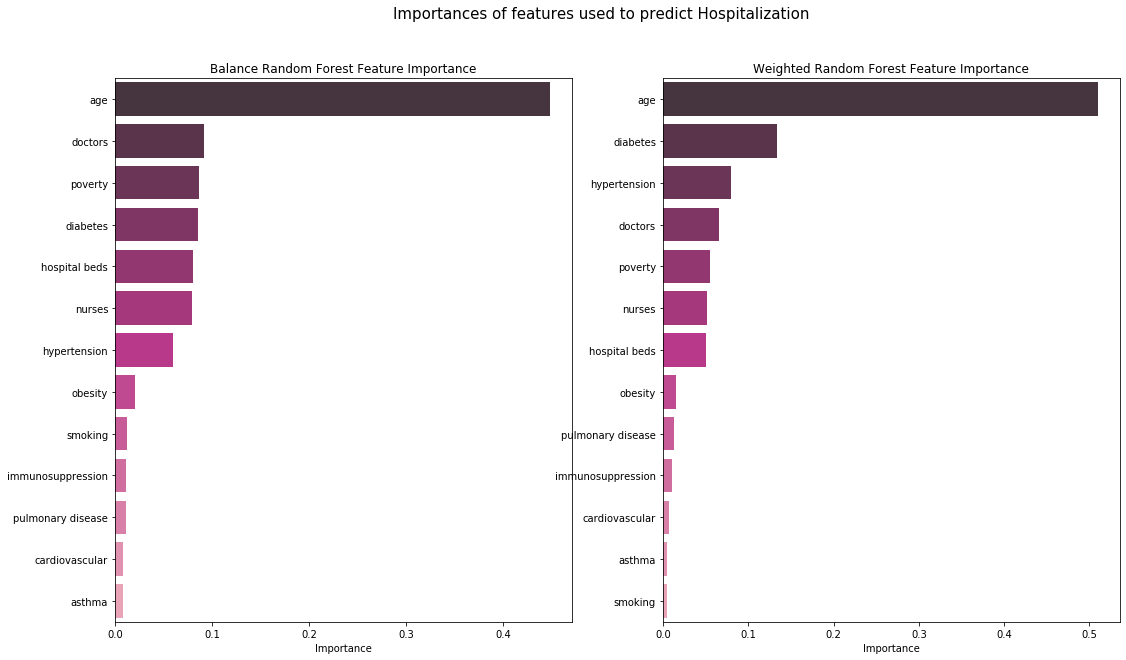

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf_h.best_estimator_, ax1), (grid_wrf_h.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="RdPu_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
fig.suptitle('Importances of features used to predict Hospitalization', size=15)
plt.show()

### 3.3 Target Variable: Severe Condition

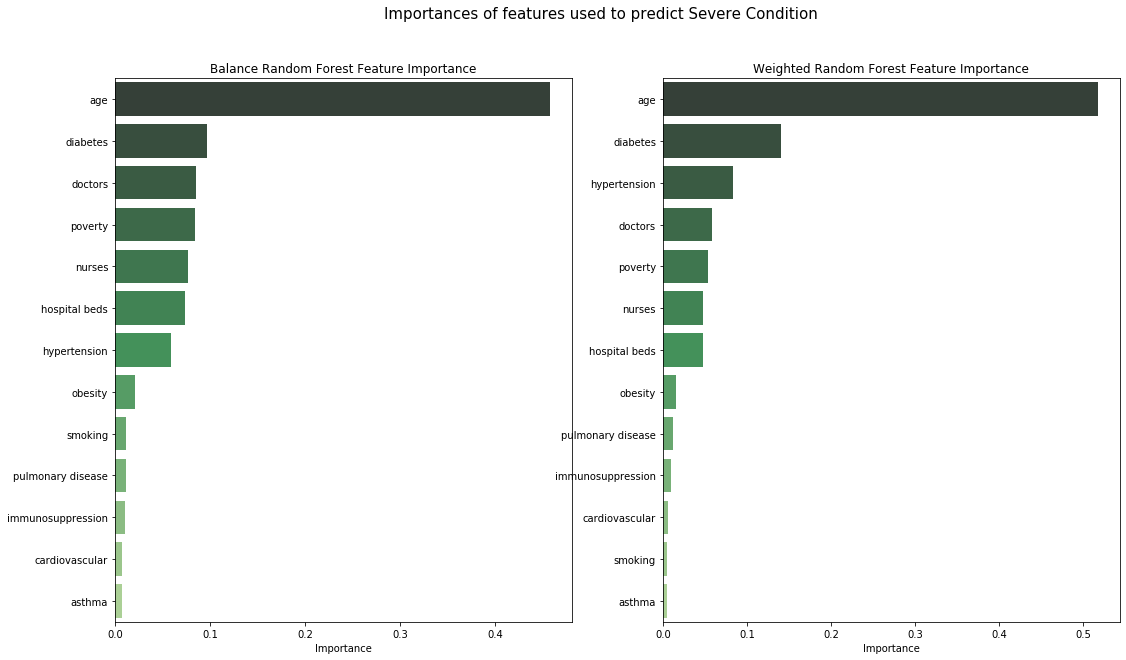

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
for model, subplot in [(grid_brf_s.best_estimator_, ax1), (grid_wrf_s.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette="YlGn_d", ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Balance Random Forest Feature Importance')
    else:
        subplot.set_title('Weighted Random Forest Feature Importance')
fig.suptitle('Importances of features used to predict Severe Condition', size=15)
plt.show()

### 3.4 Balance Random Forest with Death and Hospitalization

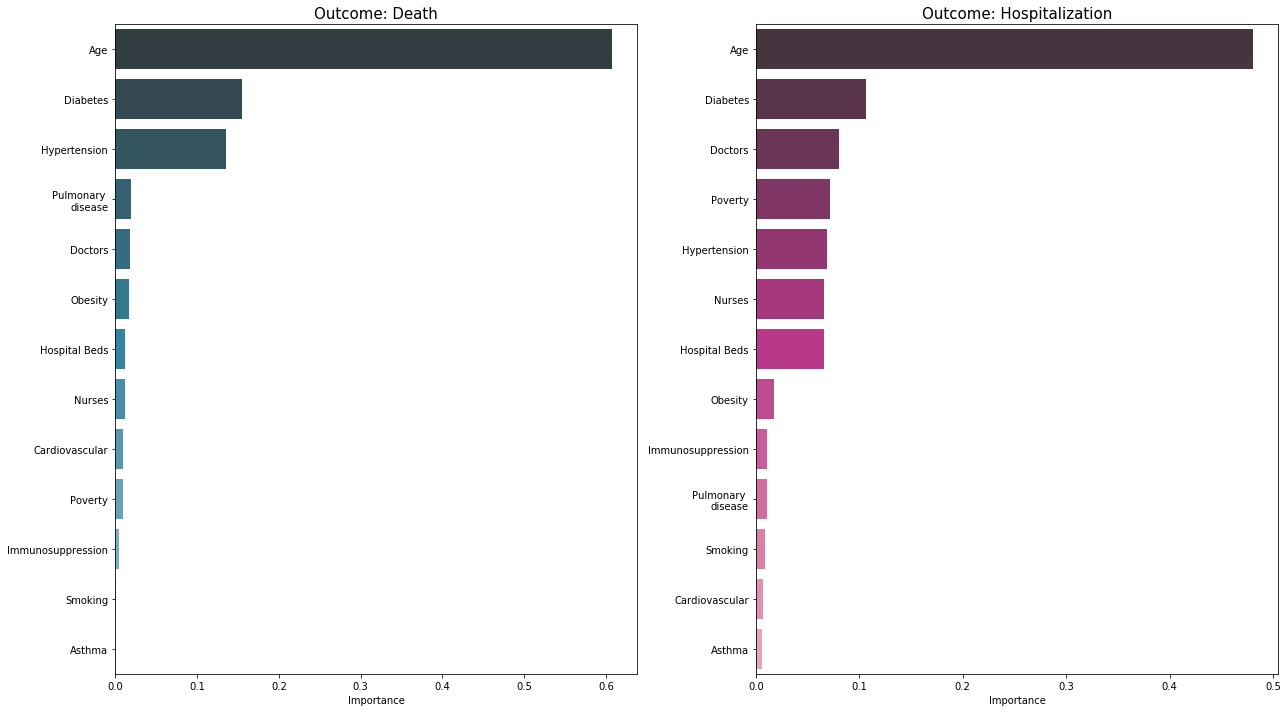

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
colors = ['PuBuGn_d','RdPu_d']
i=0
for model, subplot in [(grid_brf_d.best_estimator_, ax1), (grid_brf_h.best_estimator_, ax2)]:
    importances = model.feature_importances_
    fi = pd.DataFrame(data={'Features': features_en, 
                        'Importance': importances}).sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Features', data=fi, palette=colors[i], ax=subplot)
    subplot.set_xlabel('Importance')
    subplot.set_ylabel('')
    if subplot == ax1:
        subplot.set_title('Outcome: Death', size=15)
    else:
        subplot.set_title('Outcome: Hospitalization', size=15)
    i+=1
fig.tight_layout()
plt.show()

## 4. Identifying individual-level characteristics of individuals that the model is incorrectly predicting

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [19]:
test['pred_d'] = grid_brf_d.predict(test[features])
test['pred_h'] = grid_brf_h.predict(test[features])

In [76]:
results_en = test.groupby('entidad_res').apply(lambda x: \
                                               f1_score(x['muertos'],x['pred_d'])).reset_index(name='f1_d')
results_en['recall_d'] = test.groupby('entidad_res').apply(lambda x: \
                                                           recall_score(x['muertos'],x['pred_d'])).reset_index()[0]
results_en['precision_d'] = test.groupby('entidad_res').apply(lambda x: \
                                                           precision_score(x['muertos'],x['pred_d'])).reset_index()[0]
results_en['recall_h'] = test.groupby('entidad_res').apply(lambda x: \
                                                           recall_score(x['hospitalizado'],
                                                                        x['pred_h'])).reset_index()[0]
results_en['precision_h'] = test.groupby('entidad_res').apply(lambda x: \
                                                           precision_score(x['hospitalizado'],
                                                                           x['pred_h'])).reset_index()[0]
results_en['f1_h'] = test.groupby('entidad_res').apply(lambda x: \
                                                           f1_score(x['hospitalizado'],
                                                                           x['pred_h'])).reset_index()[0]

In [85]:
results_en.head(10)

,geometry,entidad_res,f1_d,recall_d,precision_d,recall_h,precision_h,f1_h
0,"POLYGON ((-102.28787 22.41649, -102.28753 22.4...",1,0.172414,0.625000,0.100000,0.457143,0.326531,0.380952
1,"MULTIPOLYGON (((-114.12880 28.01224, -114.1283...",2,0.474453,0.836910,0.331070,0.885185,0.642473,0.744548
2,"MULTIPOLYGON (((-109.91027 22.87937, -109.9102...",3,0.185185,0.714286,0.106383,0.586207,0.435897,0.500000
3,"MULTIPOLYGON (((-91.55142 18.28699, -91.55248 ...",4,0.432432,0.842105,0.290909,0.695652,0.524590,0.598131
4,"MULTIPOLYGON (((-92.77034 15.15128, -92.77107 ...",7,0.304000,0.775510,0.189055,0.751592,0.524444,0.617801
5,"POLYGON ((-107.65658 31.78370, -107.65314 31.7...",8,0.530120,0.846154,0.385965,0.860697,0.697581,0.770601
6,"POLYGON ((-102.31079 29.87695, -102.31050 29.8...",5,0.189655,0.611111,0.112245,0.580000,0.333333,0.423358
7,"MULTIPOLYGON (((-114.72650 18.36037, -114.7219...",6,0.344828,0.833333,0.217391,0.714286,0.833333,0.769231
8,"POLYGON ((-99.11124 19.56150, -99.11485 19.557...",9,0.323958,0.751572,0.206479,0.622807,0.482337,0.543645
9,"POLYGON ((-105.96732 26.78554, -105.93919 26.7...",10,0.466667,0.875000,0.318182,0.694444,0.581395,0.632911


In [77]:
import geopandas as gpd
state_codes = pd.read_excel('./data/description_catalogue_covid_mx.xlsx', sheet_name='Catálogo de ENTIDADES')
shape = gpd.read_file('data/mex_states_shape/mex_admbnda_adm1_govmex.shp')
shape = shape.loc[:,['ADM1_ES', 'ADM1_PCODE', 'geometry']]
shape.loc[:,'ADM1_PCODE'] = shape.ADM1_PCODE.apply(lambda row: int(row.strip('MX')))

In [78]:
#gpd.GeoDataFrame(results_en.merge)
results_en = shape.merge(results_en, right_on='entidad_res', left_on='ADM1_PCODE').loc[:,'geometry':]

### 4.1 Death Target

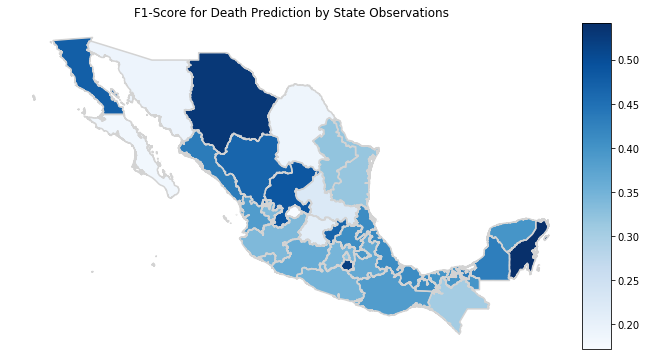

In [95]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("F1-Score for Death Prediction by State Observations")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = results_en.plot(column='f1_d', cmap='Blues', legend=True,
                          ax=ax, cax=cax)
results_en.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

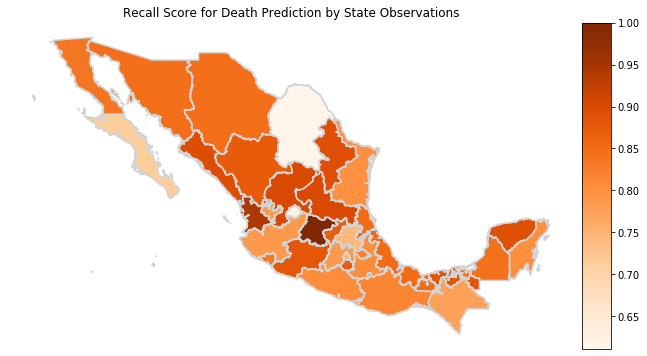

In [94]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Recall Score for Death Prediction by State Observations")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = results_en.plot(column='recall_d', cmap='Oranges', legend=True,
                          ax=ax, cax=cax)
results_en.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

### 4.2 Hospitalized Prediction

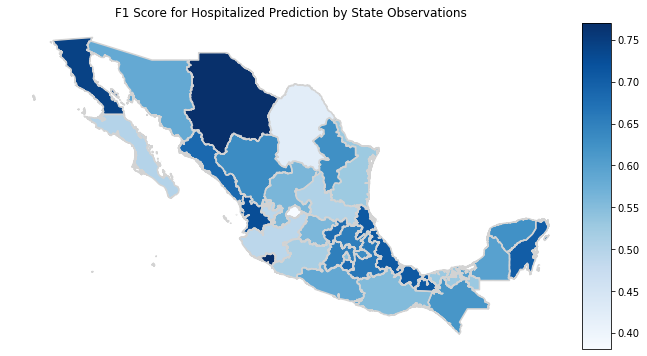

In [92]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("F1 Score for Hospitalized Prediction by State Observations")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = results_en.plot(column='f1_h', cmap='Blues', legend=True,
                          ax=ax, cax=cax)
results_en.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

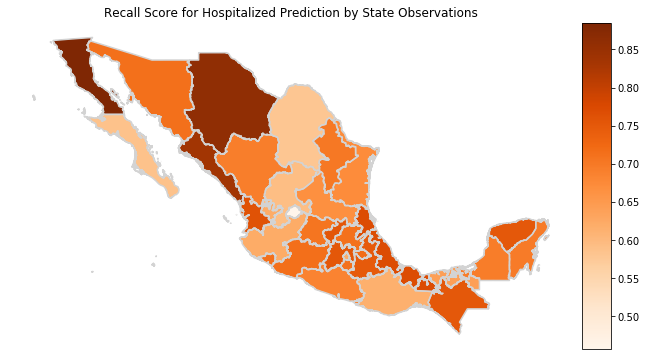

In [93]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Recall Score for Hospitalized Prediction by State Observations")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax = results_en.plot(column='recall_h', cmap='Oranges', legend=True,
                          ax=ax, cax=cax)
results_en.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()